# Objectives

Prepare the dataset for ML by:
* Encoding categorical variables appropriately for model input.
* Handling skewed or non-linear numeric features.
* Treating outliers to improve model robustness.
* Removing multicollinear or redundant features.
* Saving consistent train/test datasets after transformations.

# Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv: cleaned training dataset from the Data Cleaning notebook.
* outputs/datasets/cleaned/TestSetCleaned.csv: cleaned test dataset from the Data Cleaning notebook.

# Outputs

* outputs/datasets/engineered/TrainSetEngineered.csv: fully transformed and engineered training dataset.
* outputs/datasets/engineered/TestSetEngineered.csv: fully transformed and engineered test dataset.

Additional Comments
* This notebook focuses only on the cleaned house records.
* The inherited_houses.csv data will be transformed later, using the same pipeline, once the final model is trained.

# Change Working Directory

In [1]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


# Load Cleaned Data

In [ ]:
# Load required libraries
import pandas as pd
import os

# Load cleaned data
train_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
test_path = "outputs/datasets/cleaned/TestSetCleaned.csv"

TrainSet = pd.read_csv(train_path)
TestSet = pd.read_csv(test_path)

print("TrainSet:", TrainSet.shape)
print("TestSet:", TestSet.shape)
TrainSet.head(3)

✅ TrainSet: (1168, 22)
✅ TestSet: (292, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,8400,70.0,0.0,0,6,5,1314,1957,1957,145000
1,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,7837,59.0,0.0,40,7,6,799,1993,1994,178000
2,796,0.0,2.0,No,0,Unf,796,0,Unf,1980.0,...,8777,67.0,0.0,0,7,5,796,1910,1950,85000


# Feature Engineering

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
import sys


def FeatureEngineeringAnalysis(TrainSet, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(TrainSet)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in TrainSet.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, TrainSet[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = TrainSet[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(TrainSet):
    if TrainSet.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



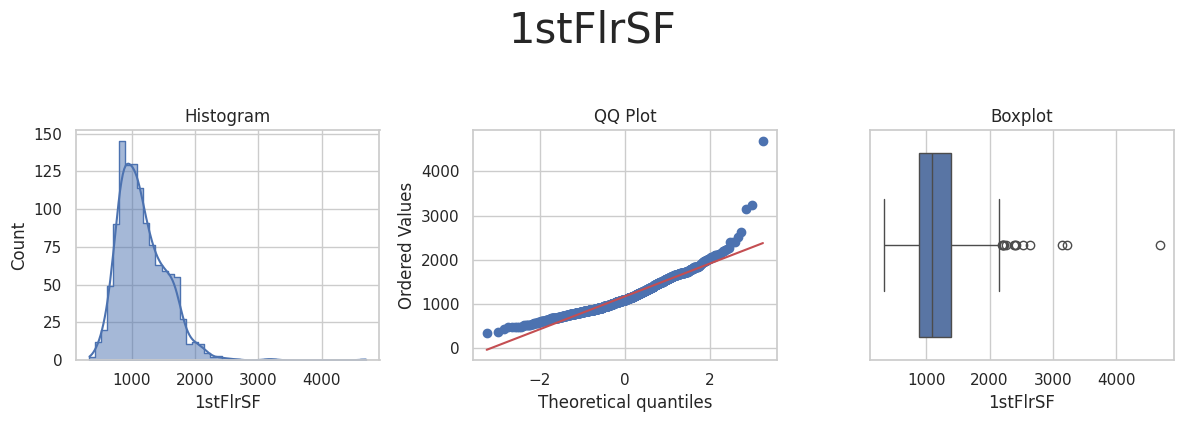

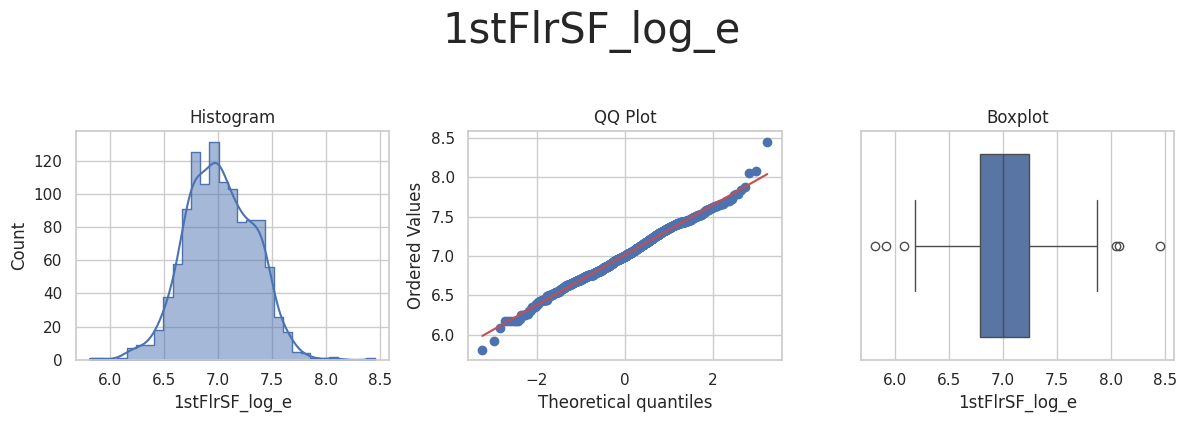

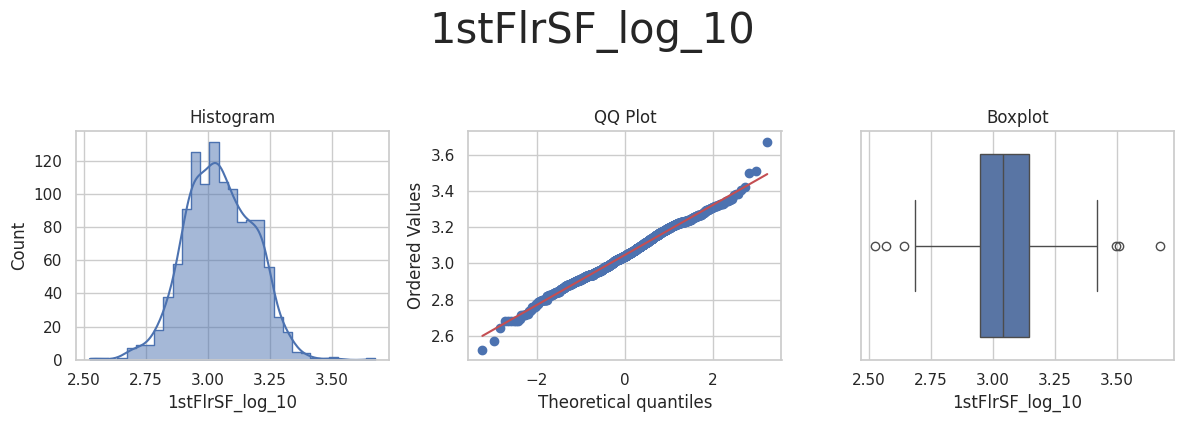

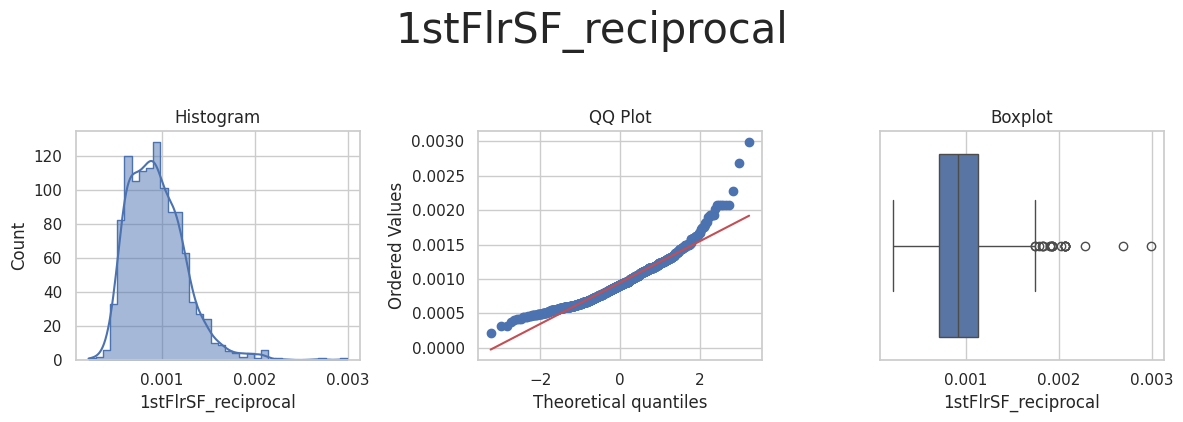

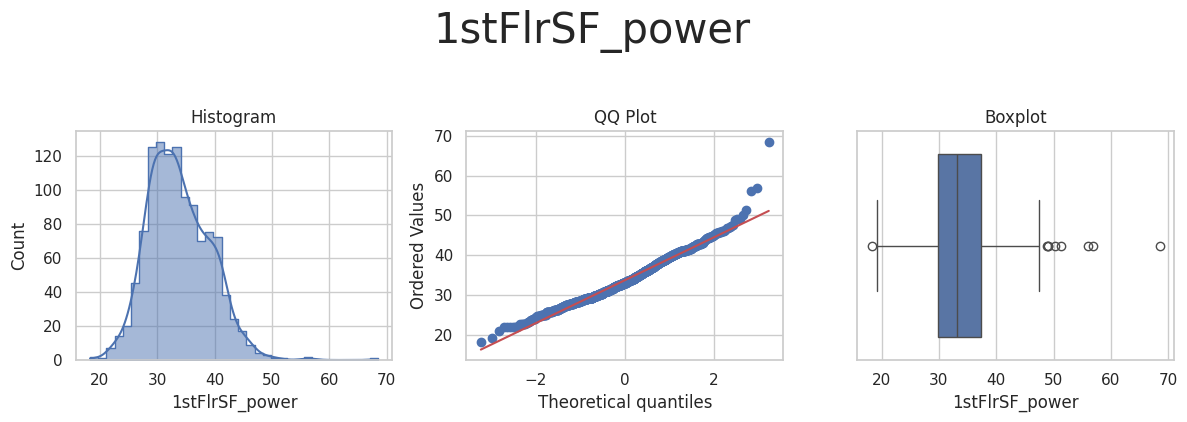

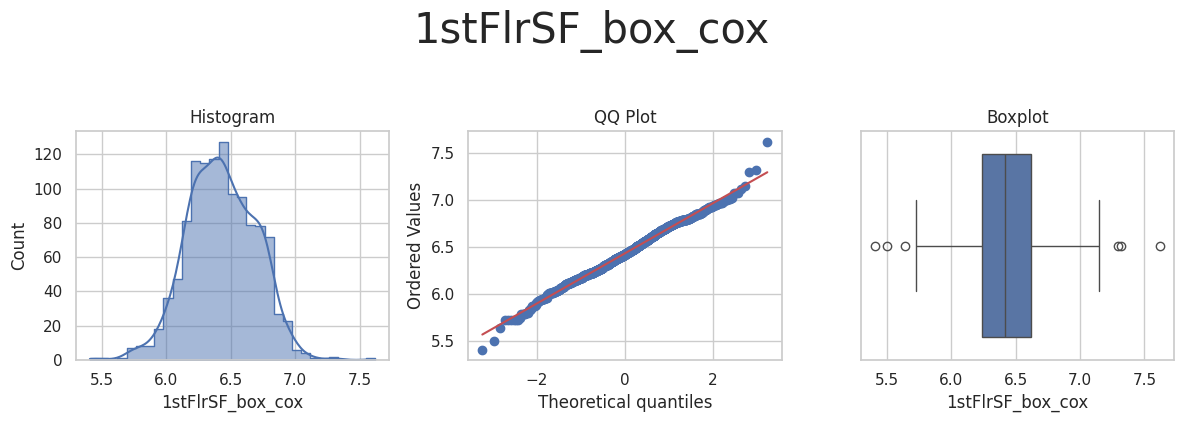

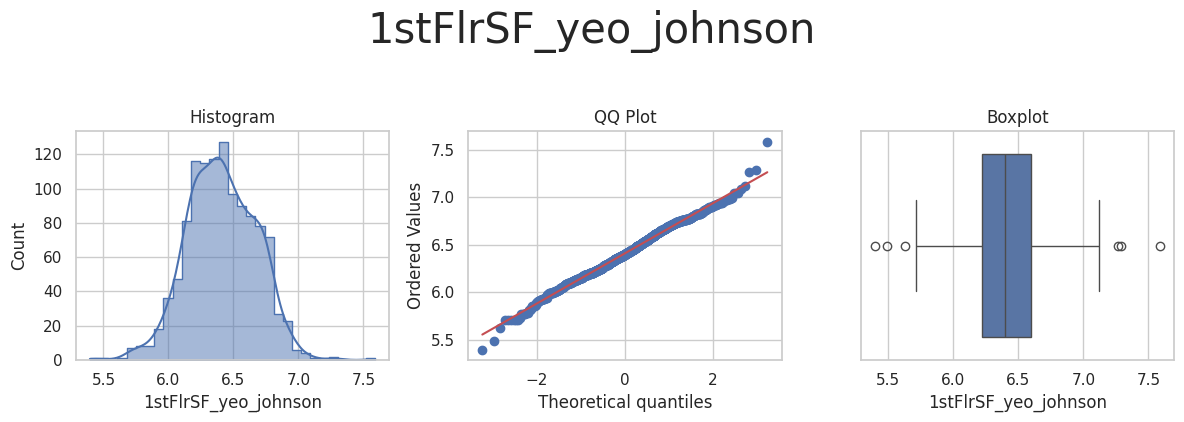



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



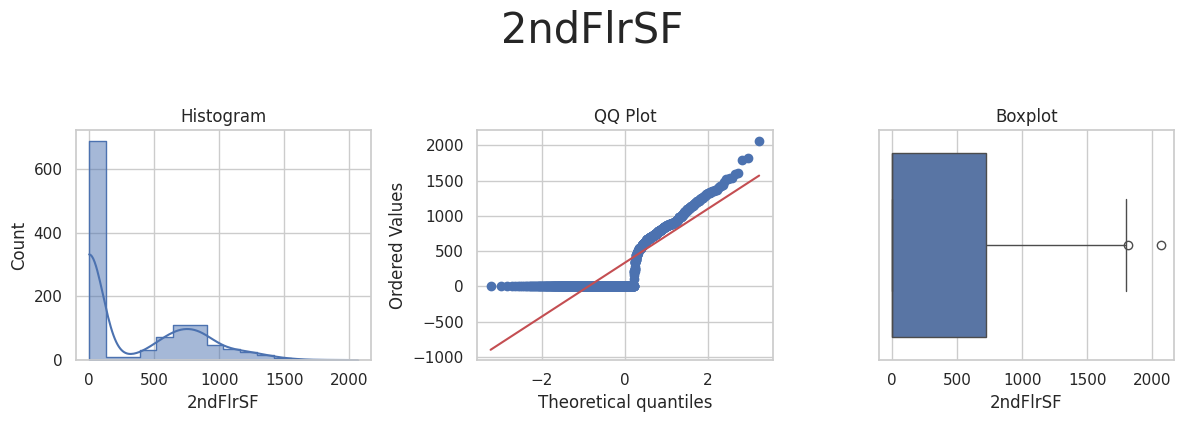

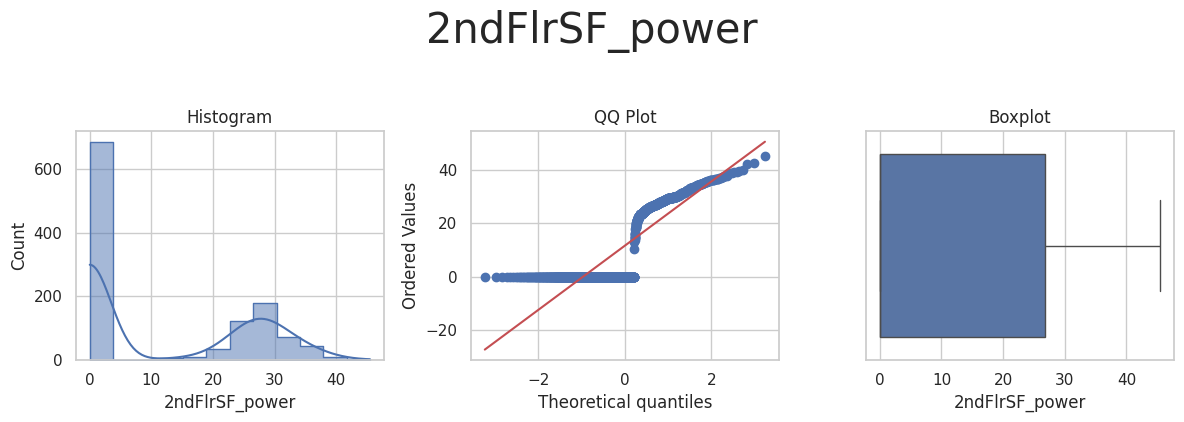

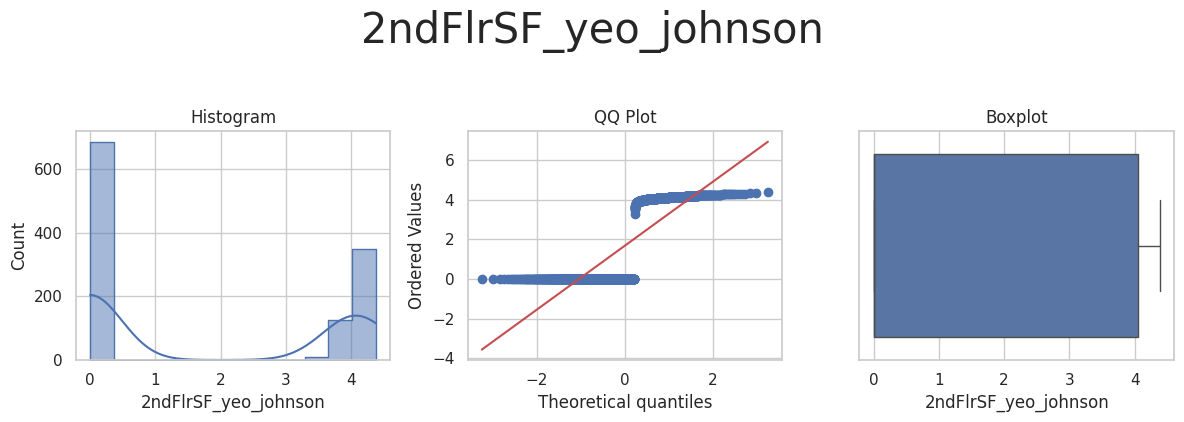



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



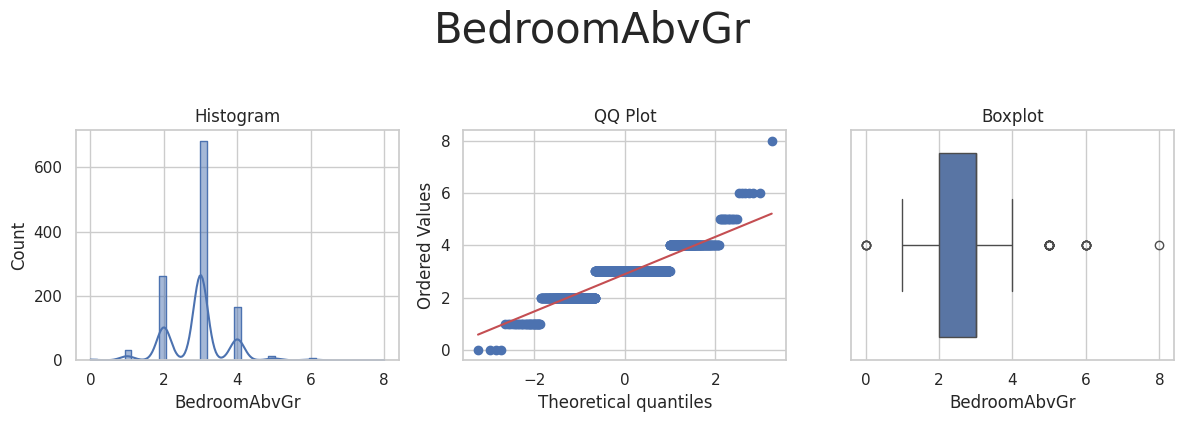

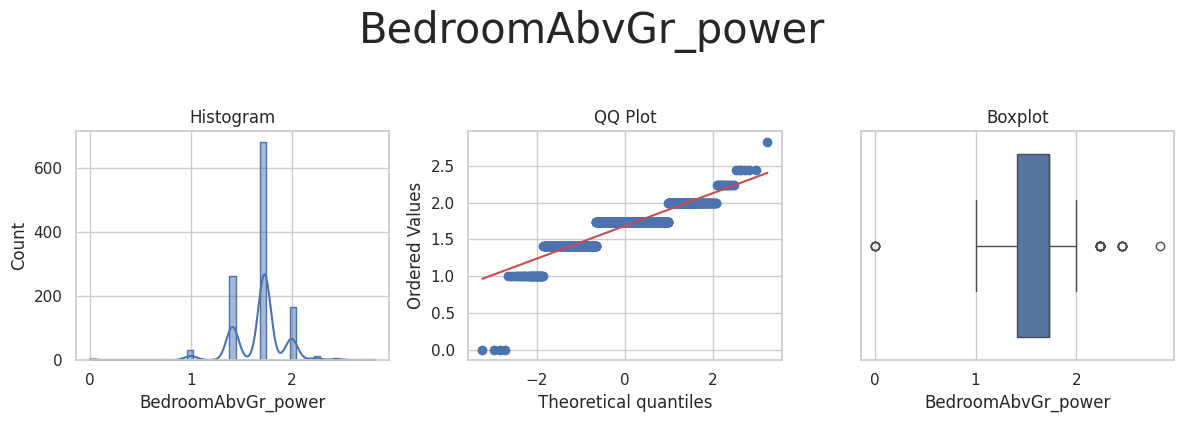

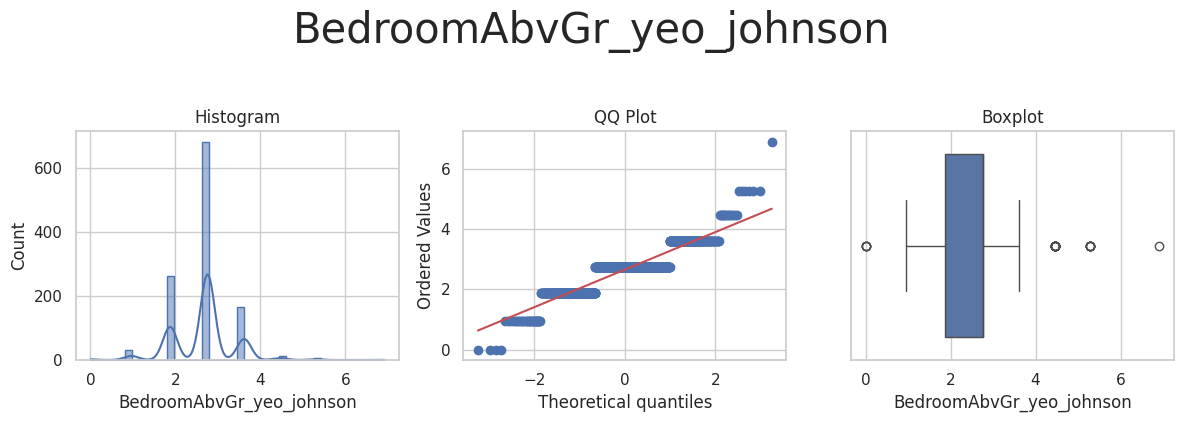



* Variable Analyzed: BsmtExposure
* Applied transformation: [] 



TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

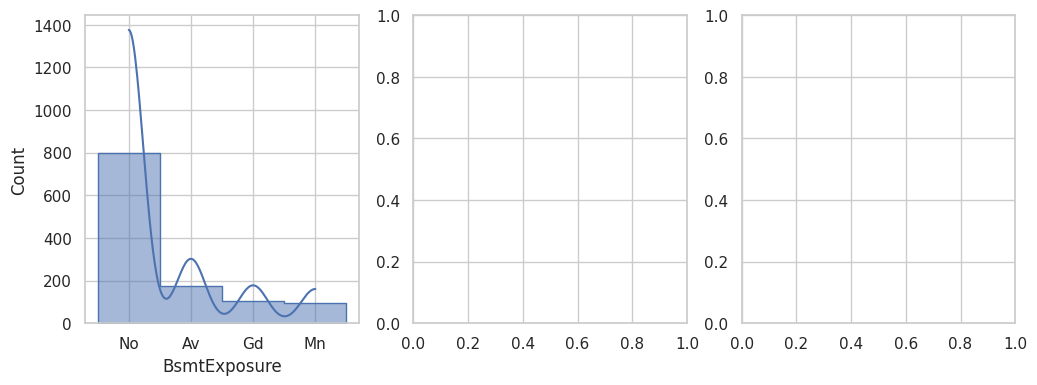

In [15]:
df_transformed, methods_worked = FeatureEngineeringAnalysis(TrainSet, analysis_type='numerical')
print("Summary of methods worked per column:")
for col, methods in methods_worked.items():
    print(f"{col}: {methods}")

# Categorical Encoding - Ordinal

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



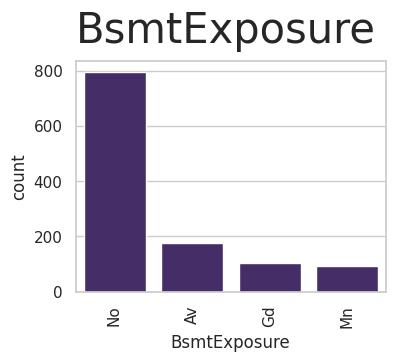

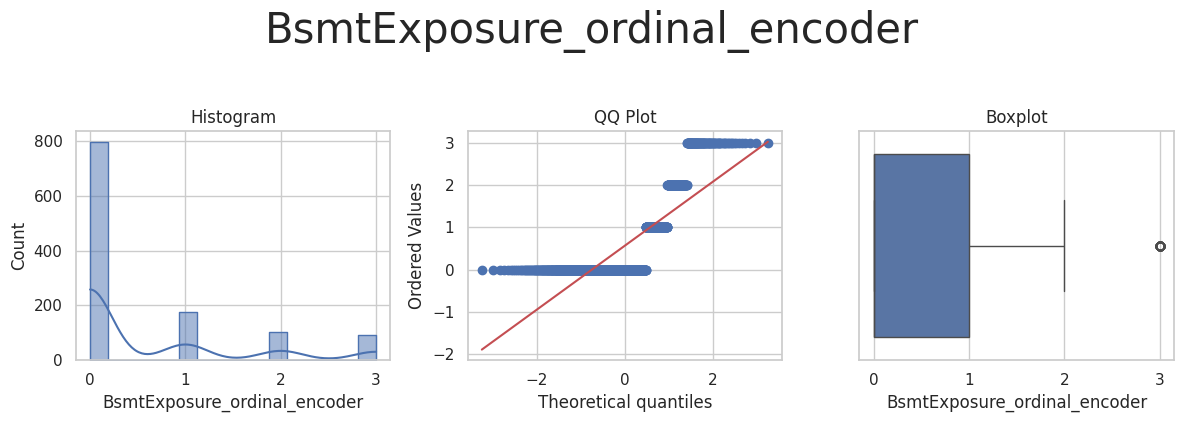



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



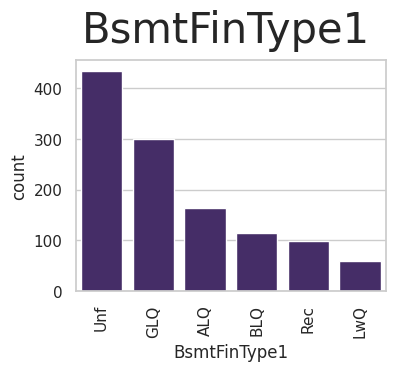

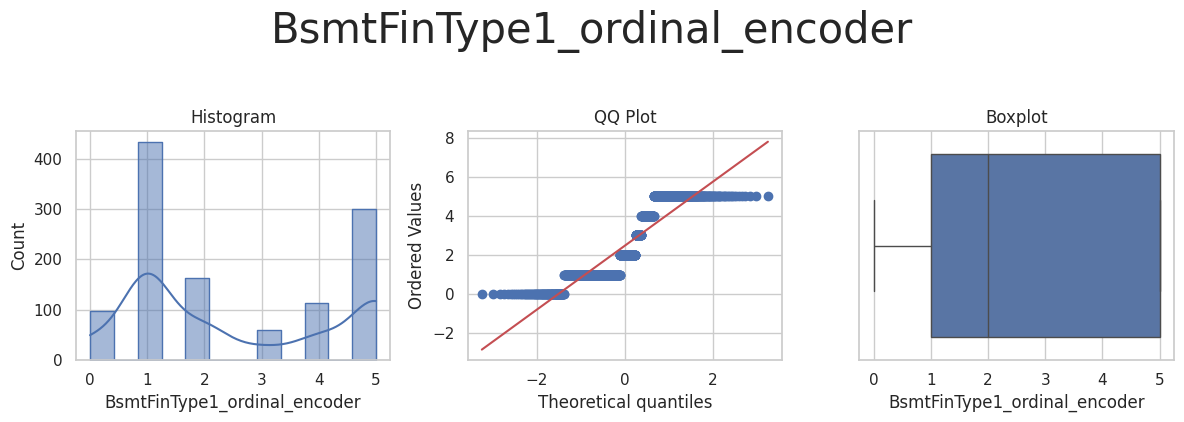



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



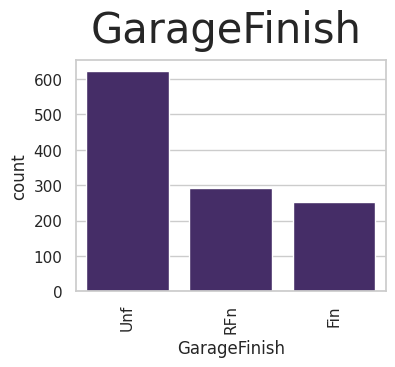

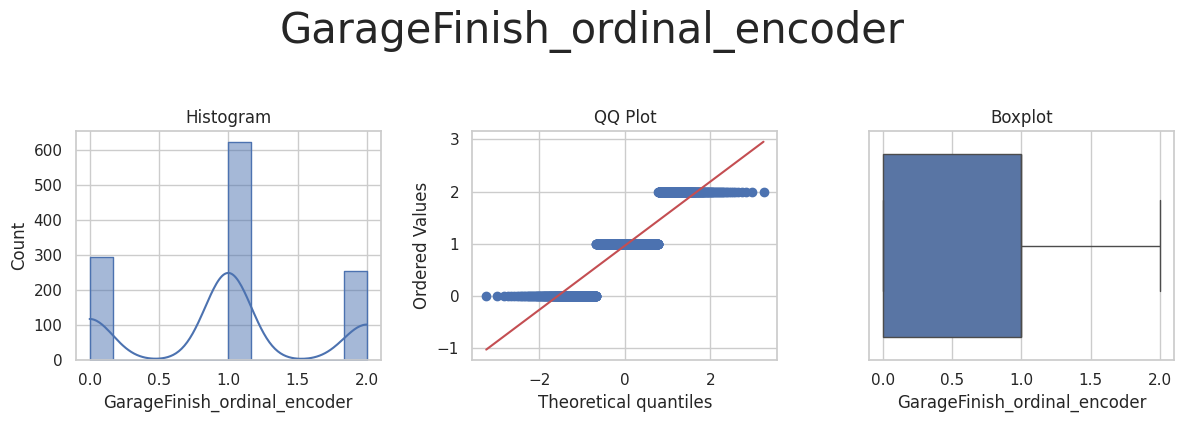



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



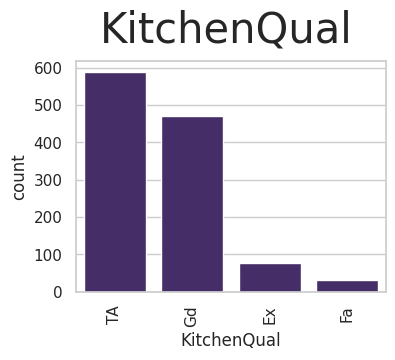

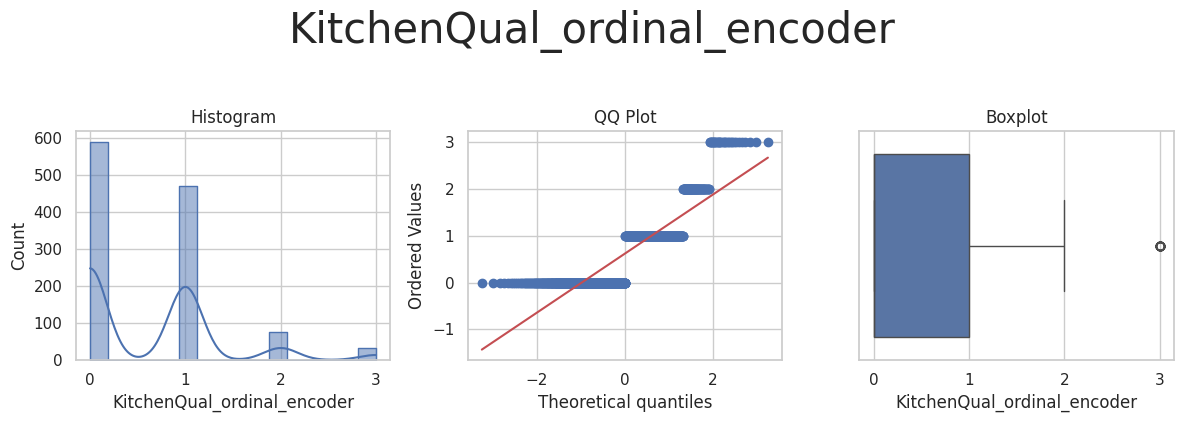



Categorical encoding - ordinal transformation done!


In [16]:
# Categorical variables from your dataset:
categorical_vars = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

df_cat = TrainSet[categorical_vars].copy()
df_cat = FeatureEngineeringAnalysis(df_cat, analysis_type='ordinal_encoder')

# Apply ordinal encoding to Train and Test sets
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_vars)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("Categorical encoding - ordinal transformation done!")



# Numerical Feature Transformation

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



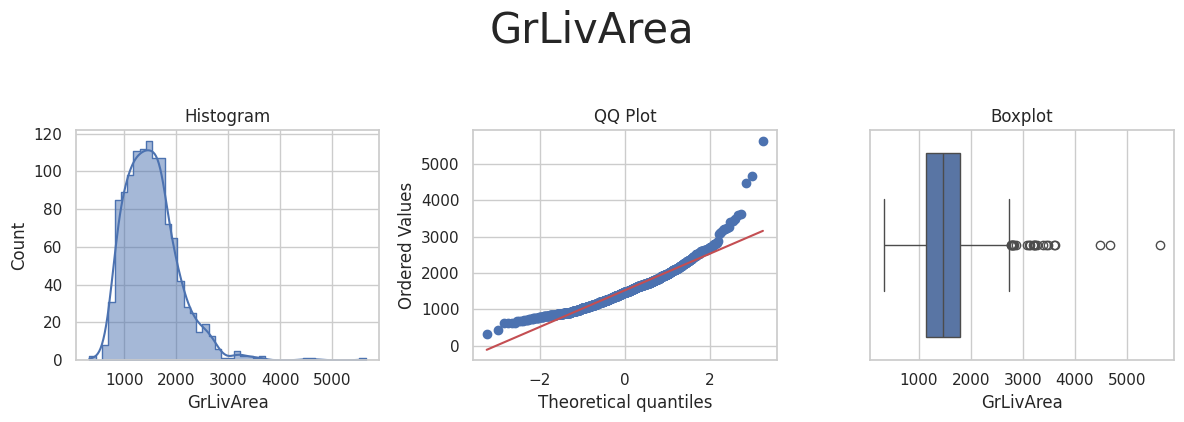

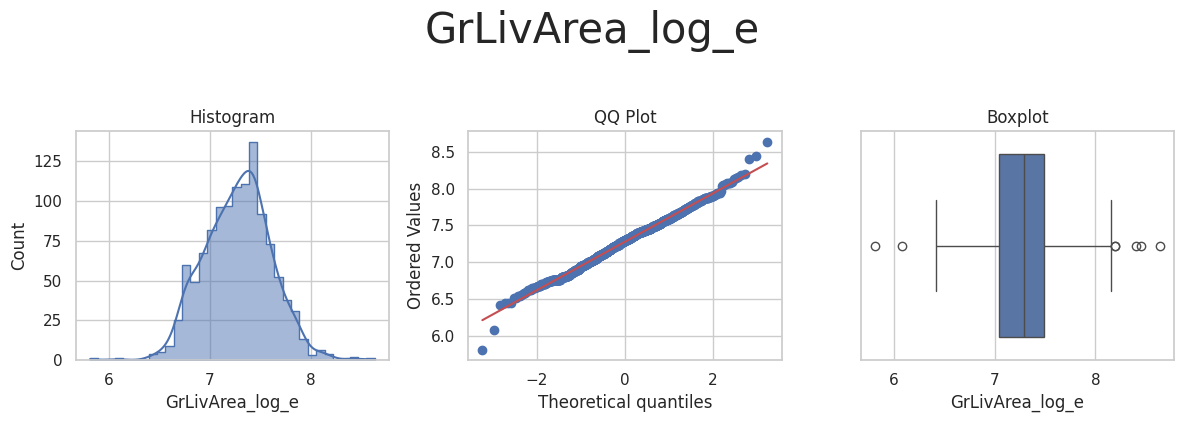

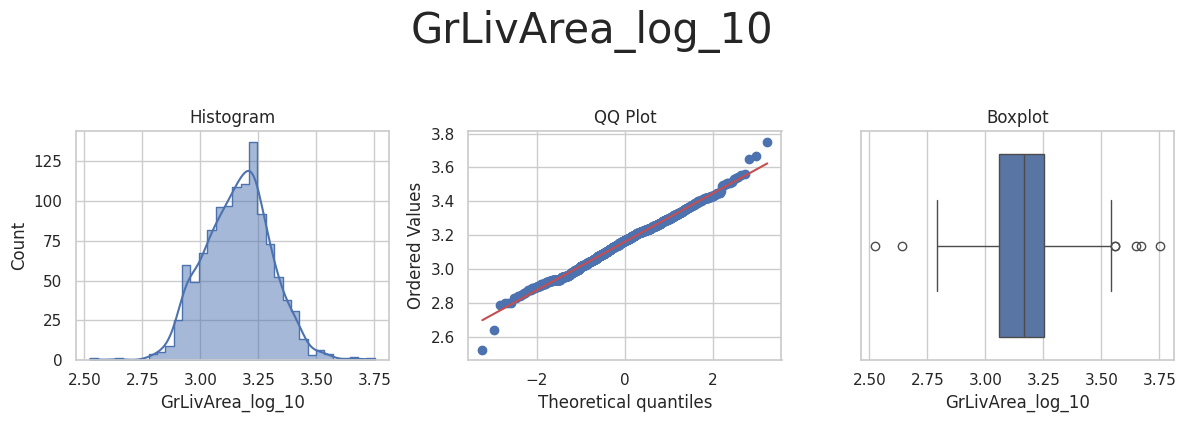

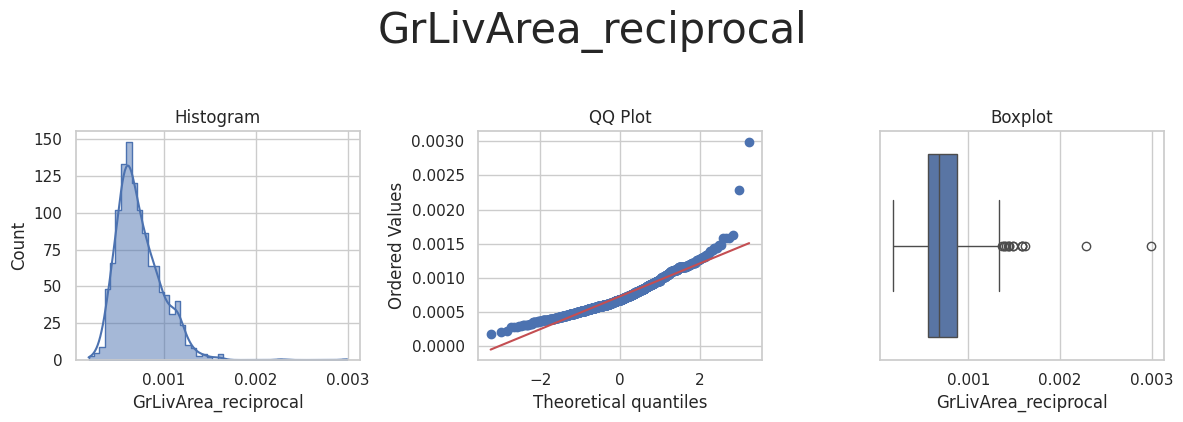

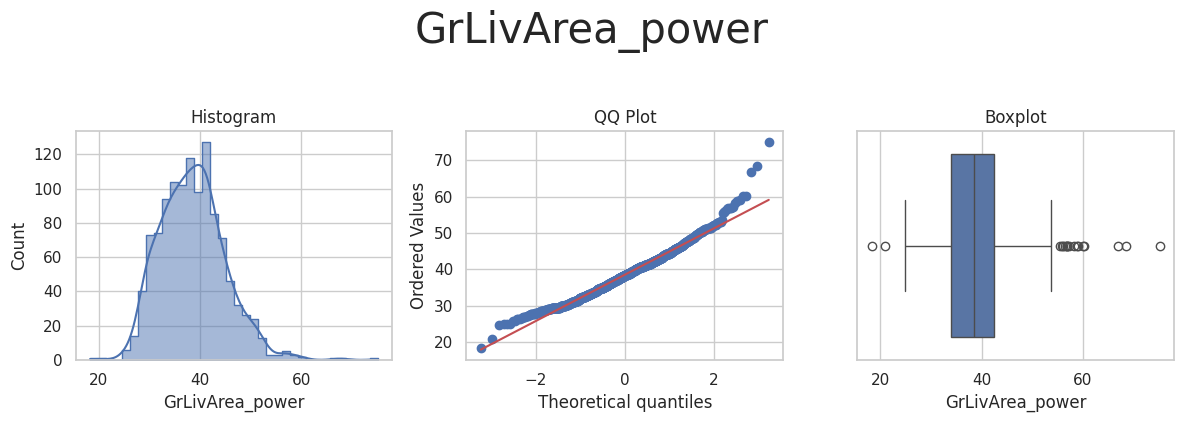

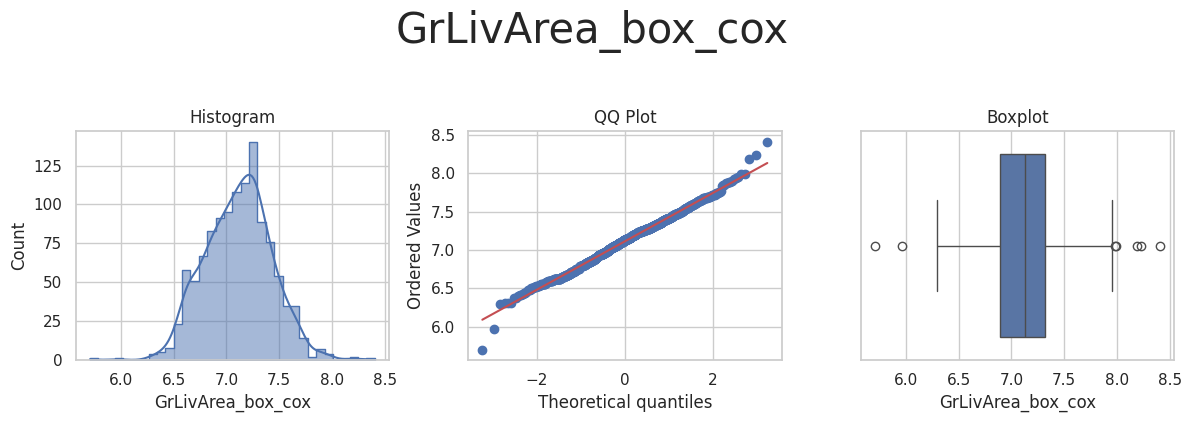

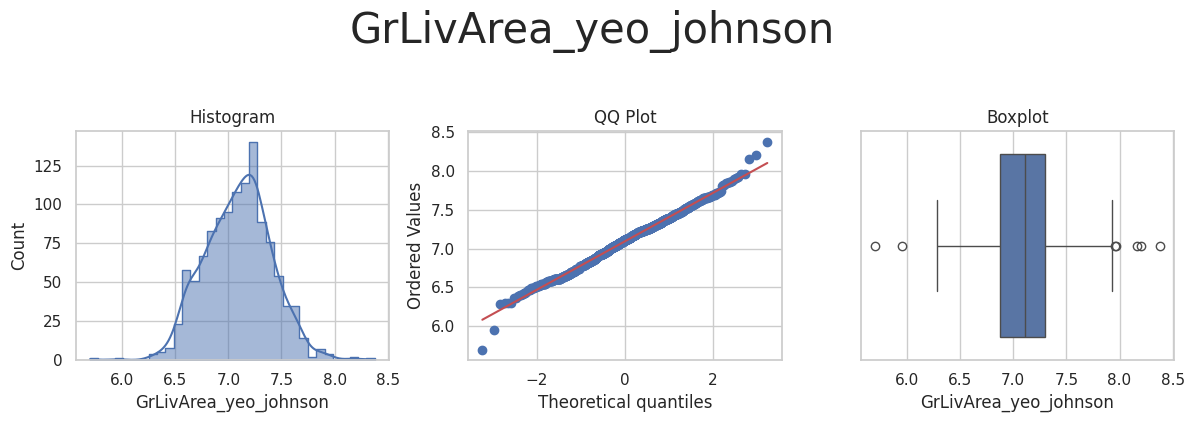



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



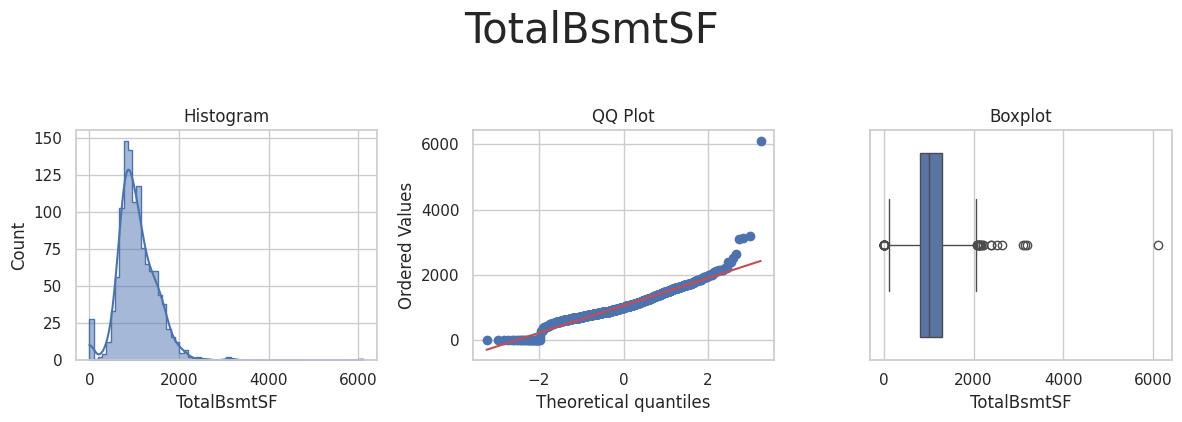

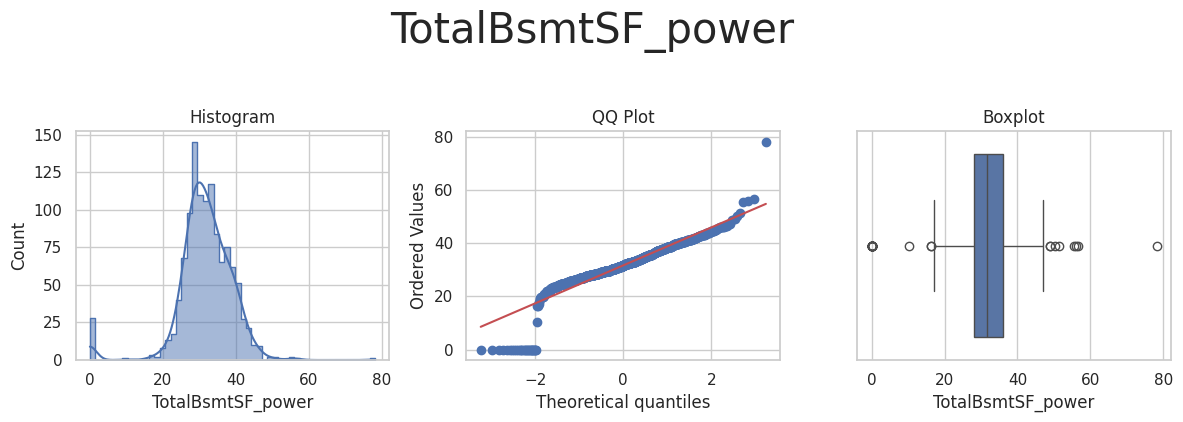

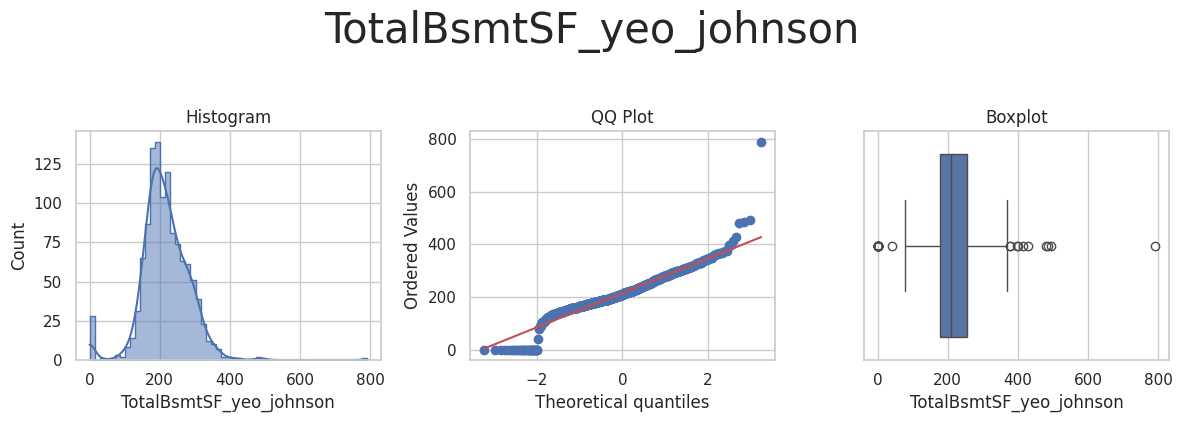



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



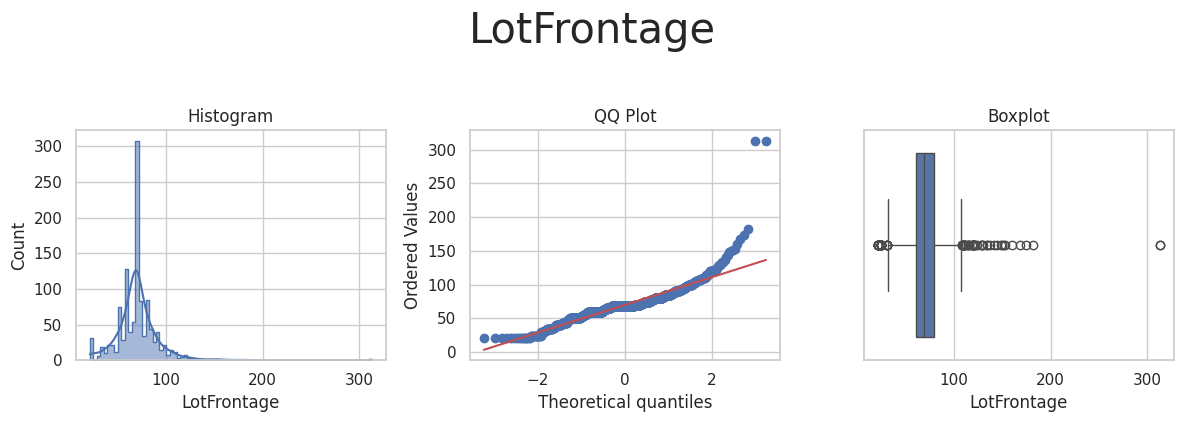

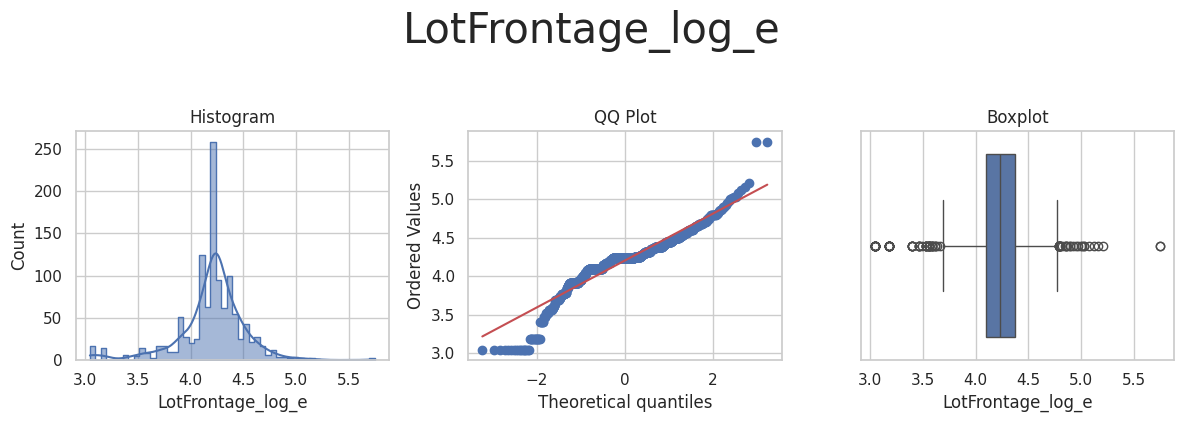

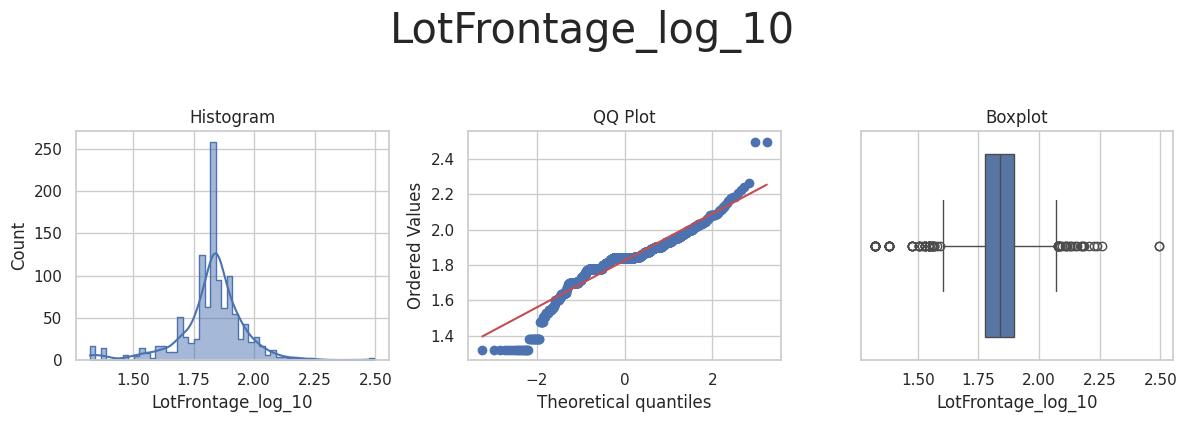

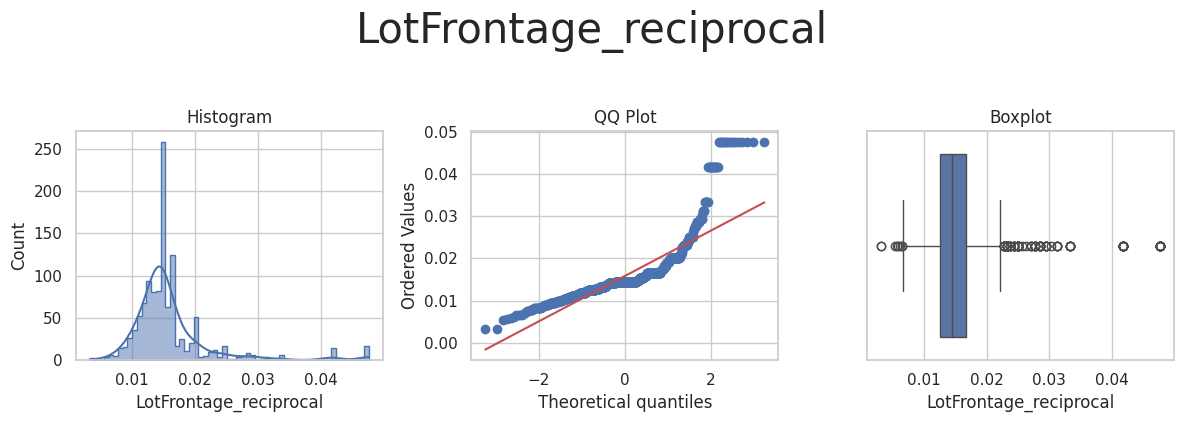

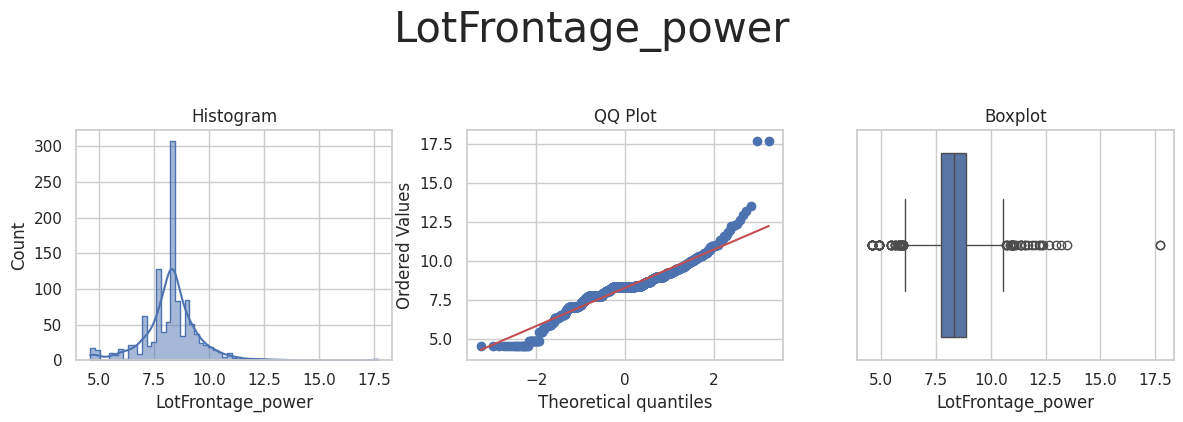

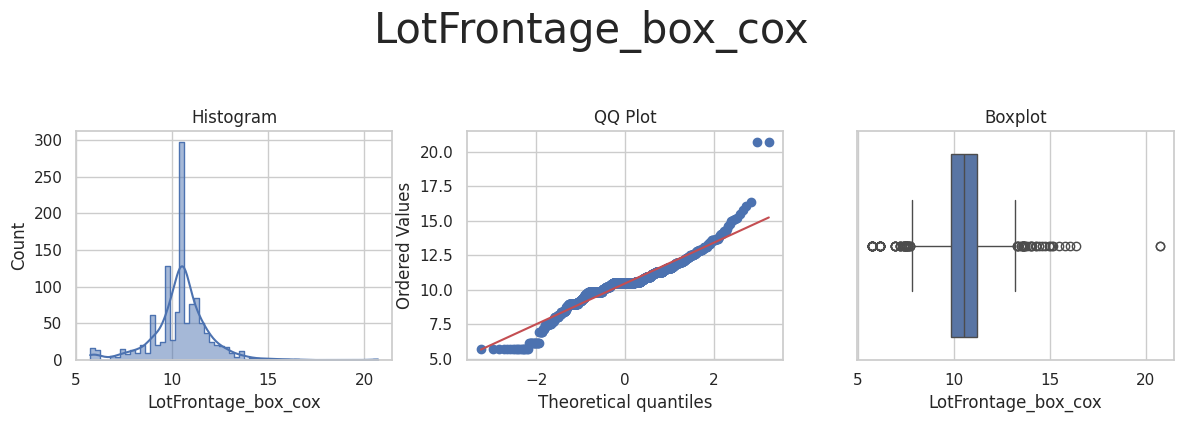

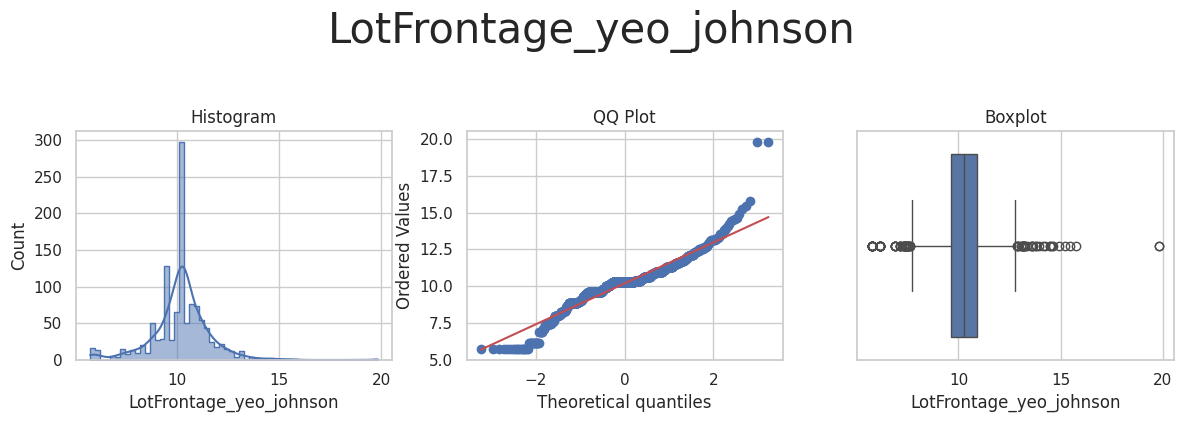



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



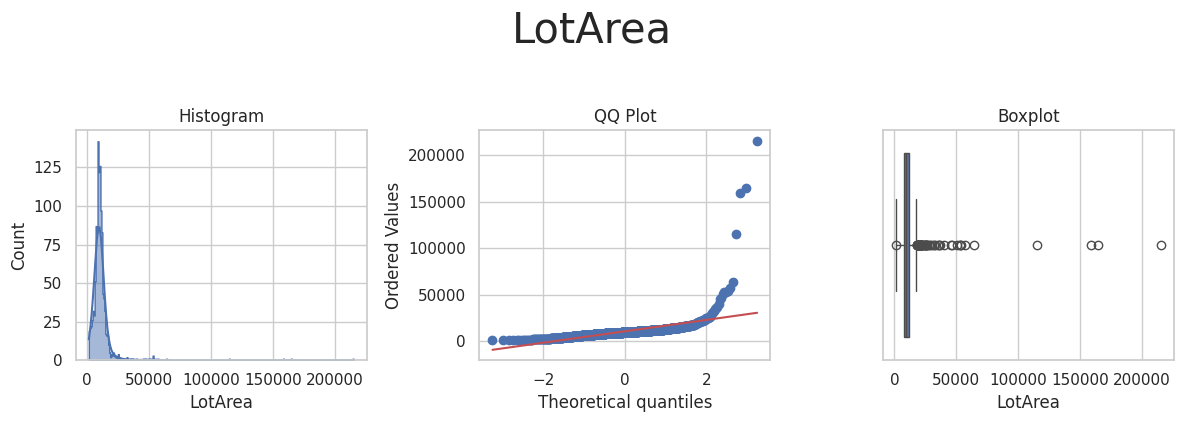

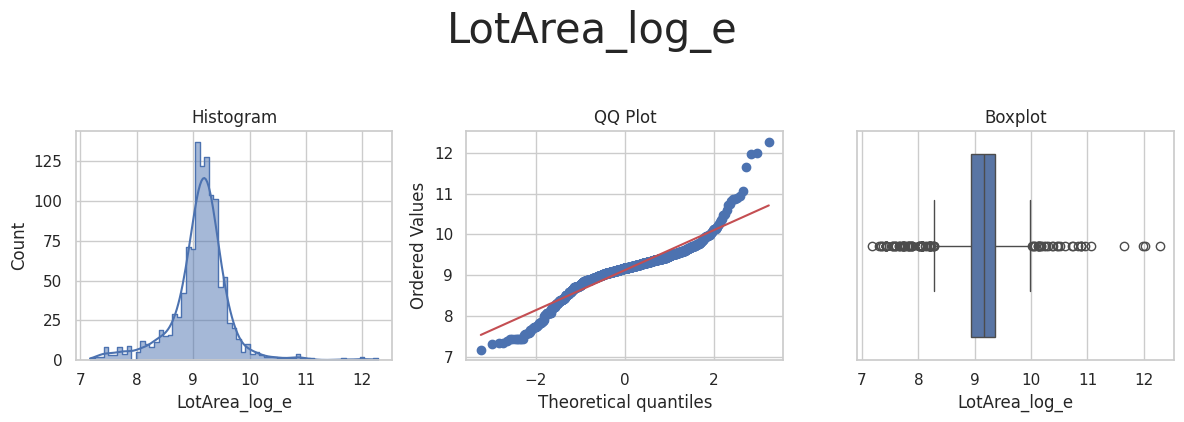

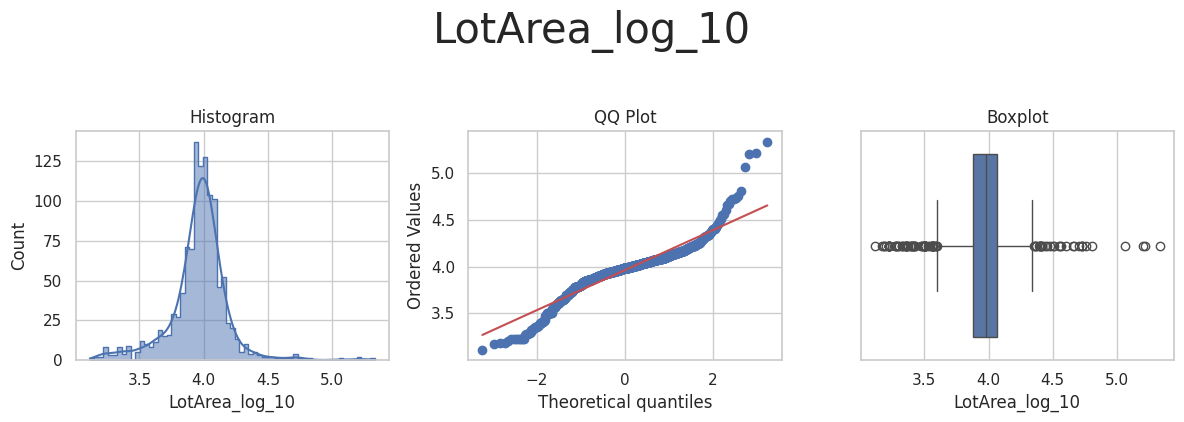

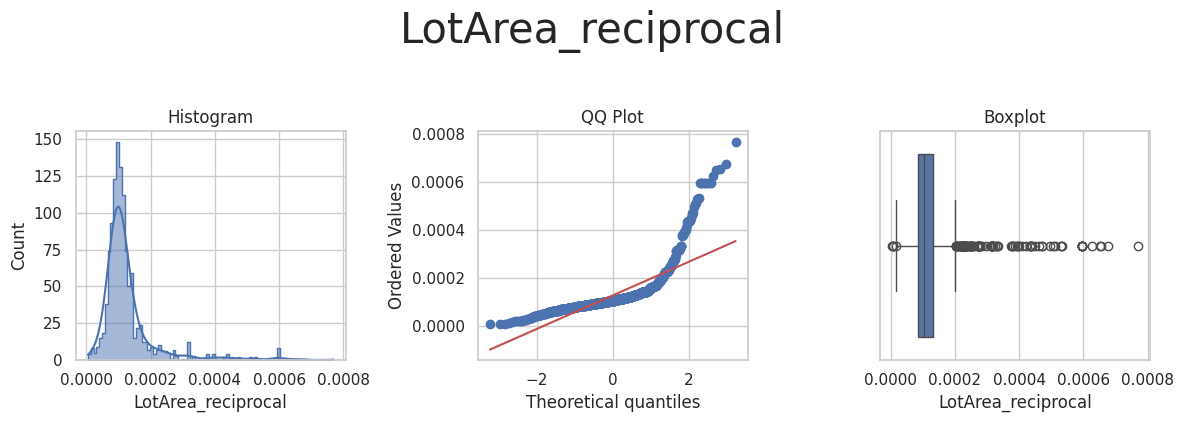

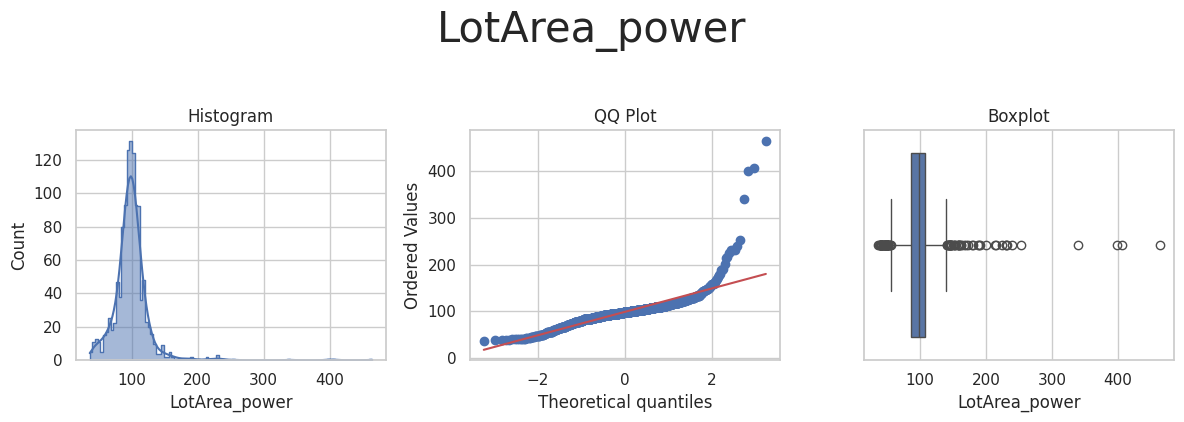

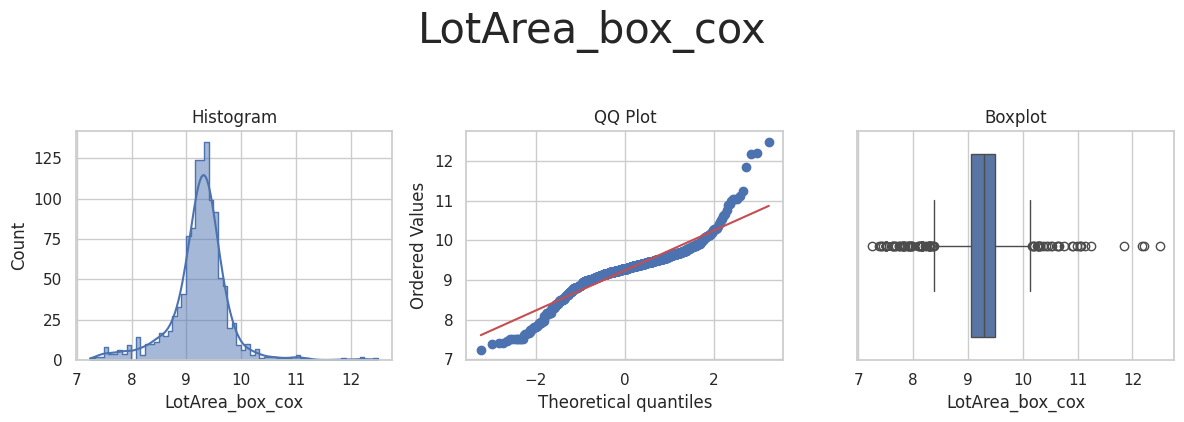

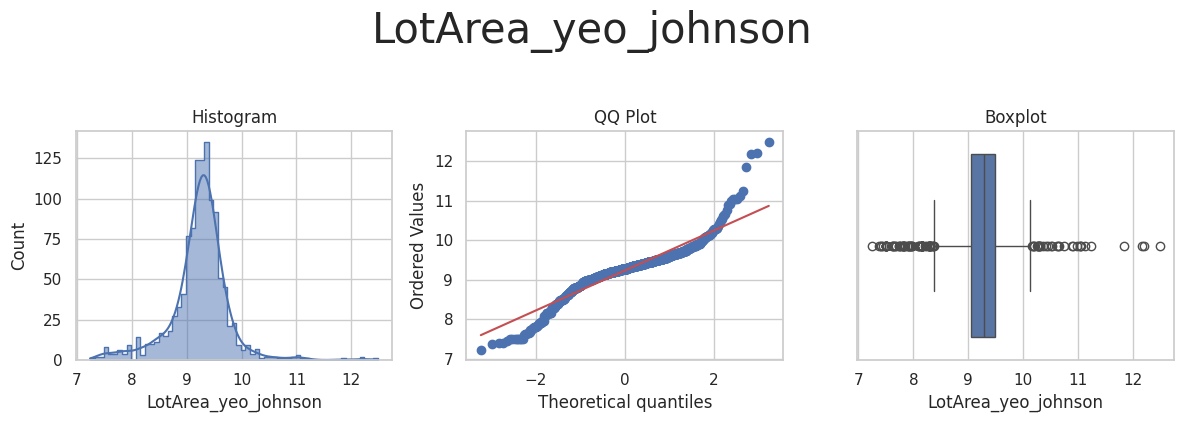



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



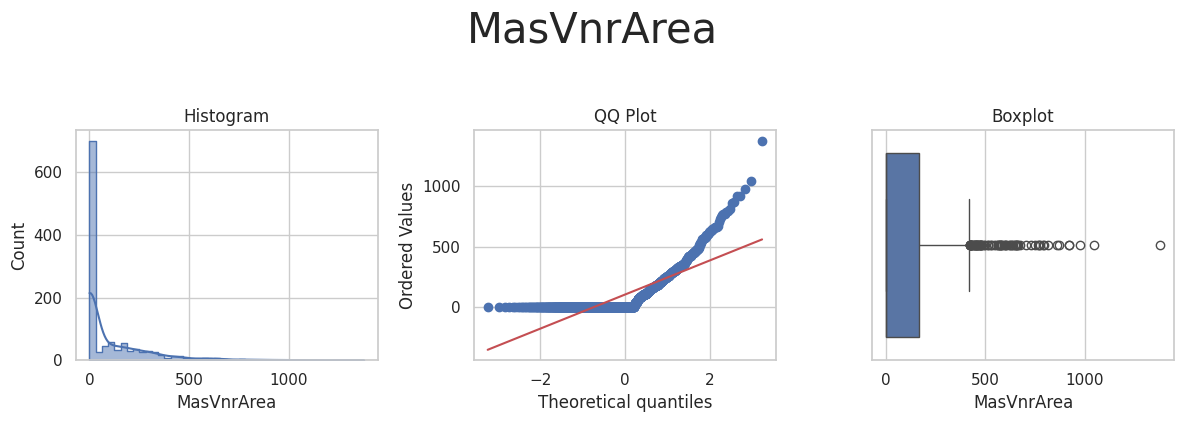

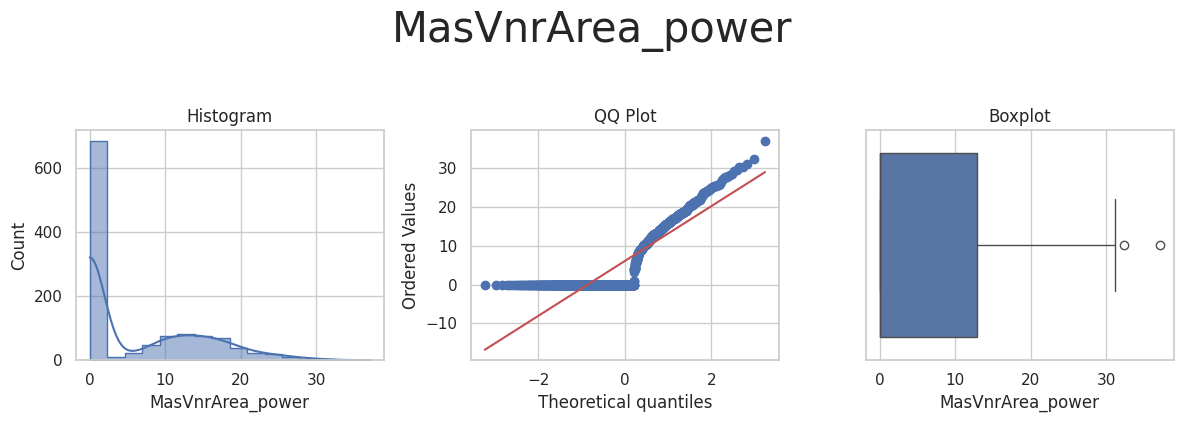

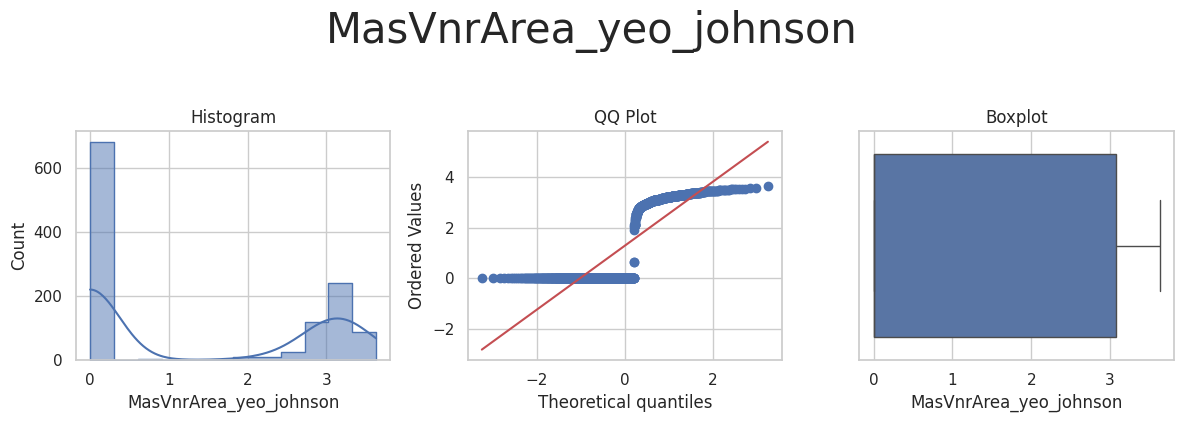



ℹ️ No numerical transformation applied in this notebook.


In [18]:
# Select numerical variables for possible transformation
num_vars = ['GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'LotArea', 'MasVnrArea']

# Inspect transformations
df_engineering = TrainSet[num_vars].copy()
FeatureEngineeringAnalysis(TrainSet=df_engineering, analysis_type="numerical")

# (Optional) If no transformation is effective, skip applying
print("ℹ️ No numerical transformation applied in this notebook.")

# Outlier Handling

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_iqr'] 



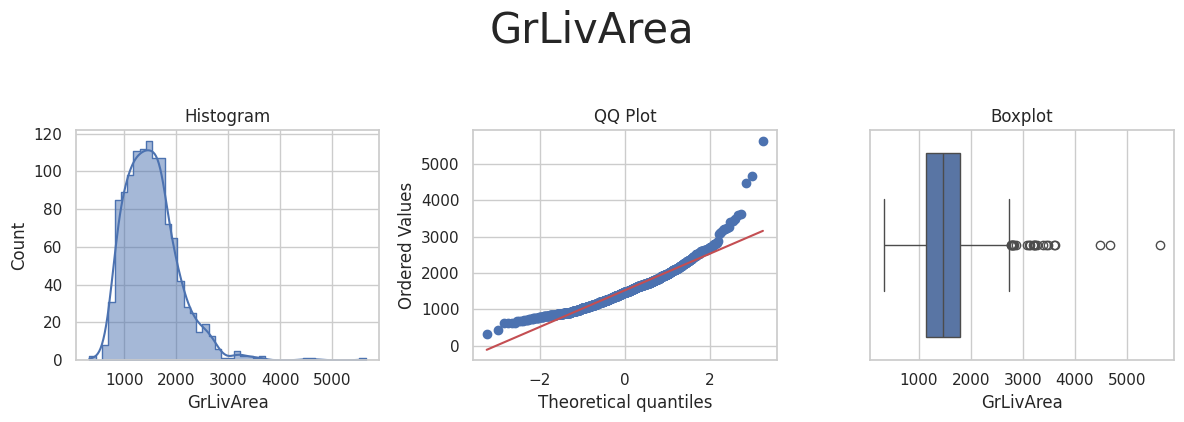

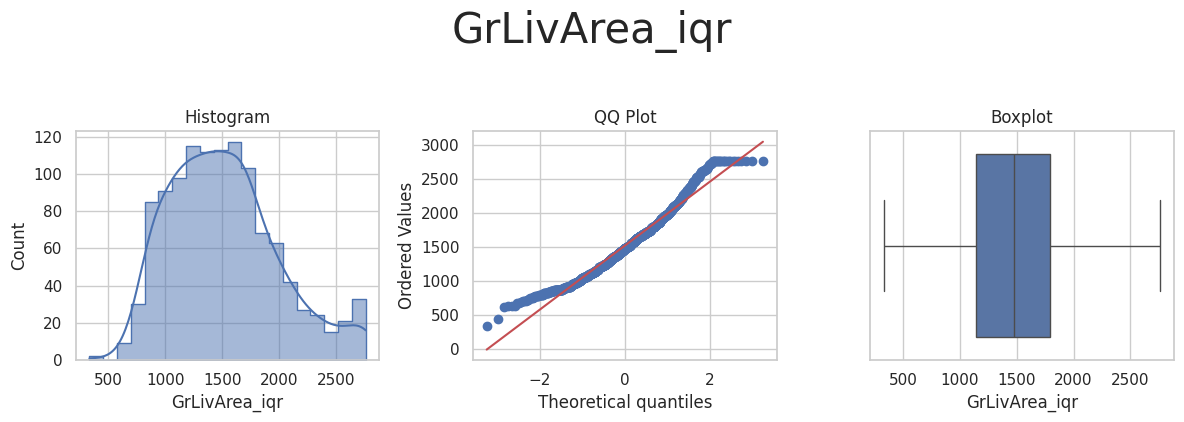



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_iqr'] 



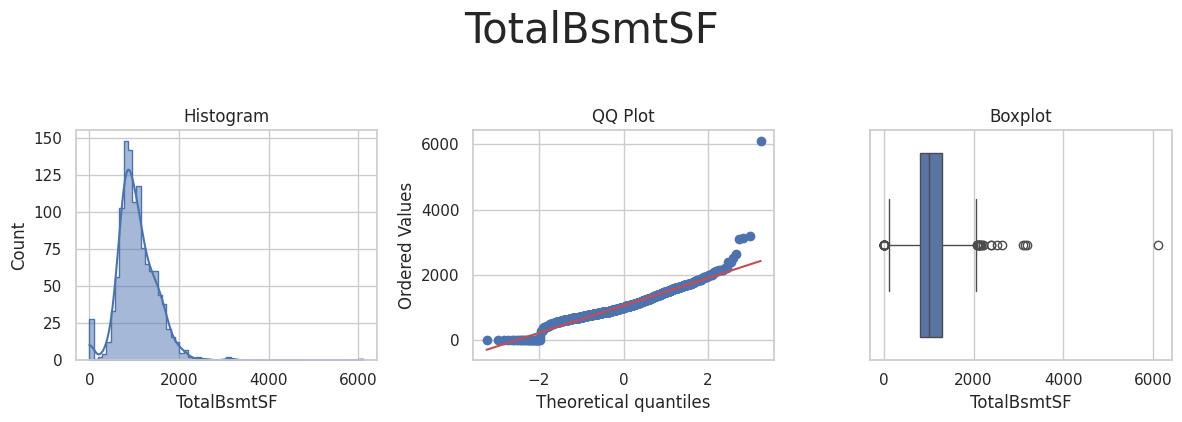

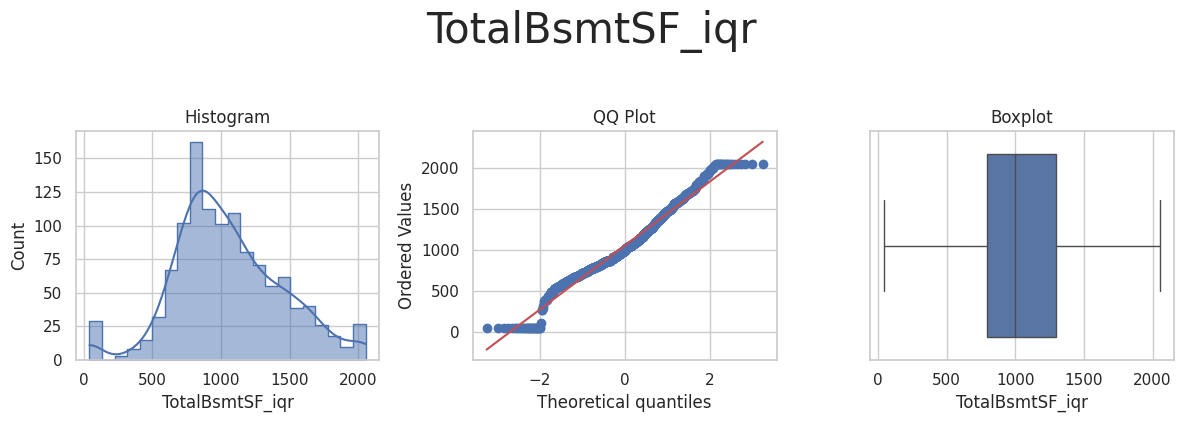



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



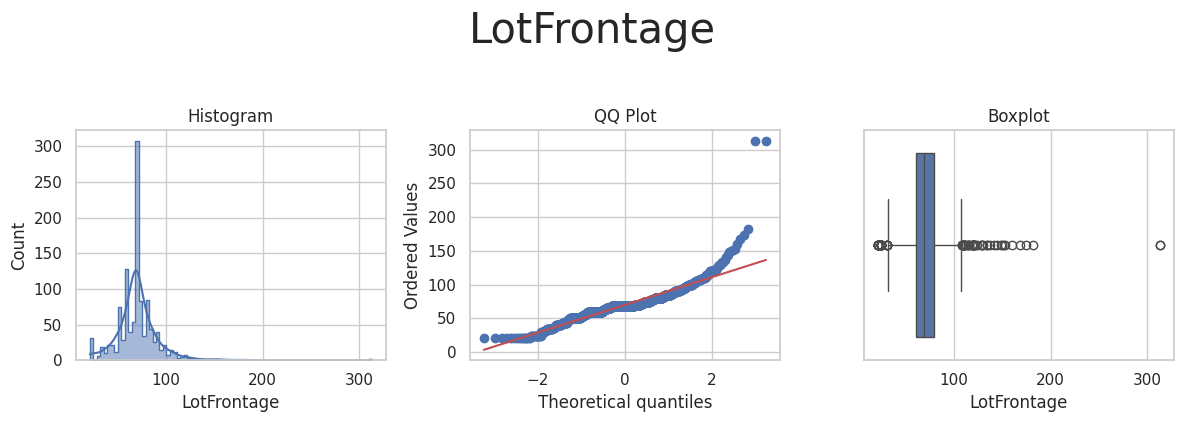

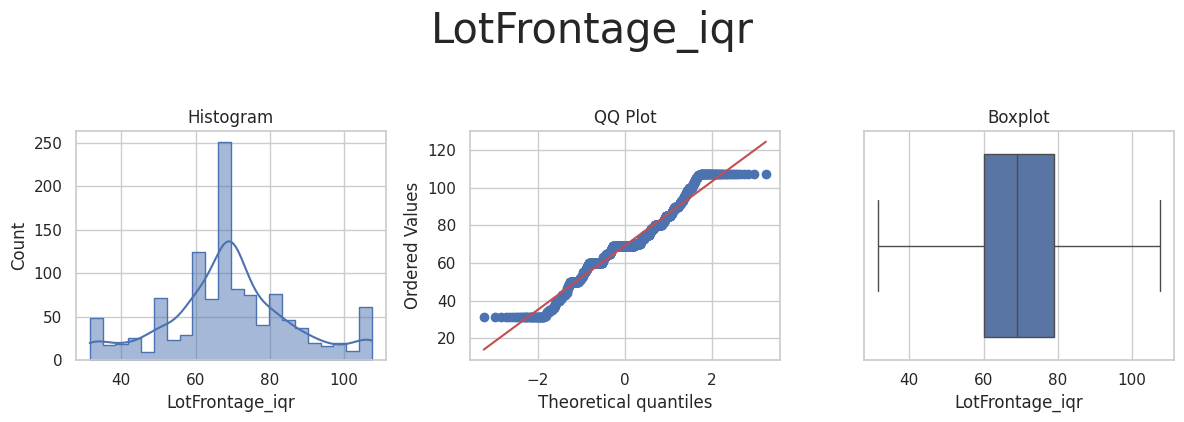



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



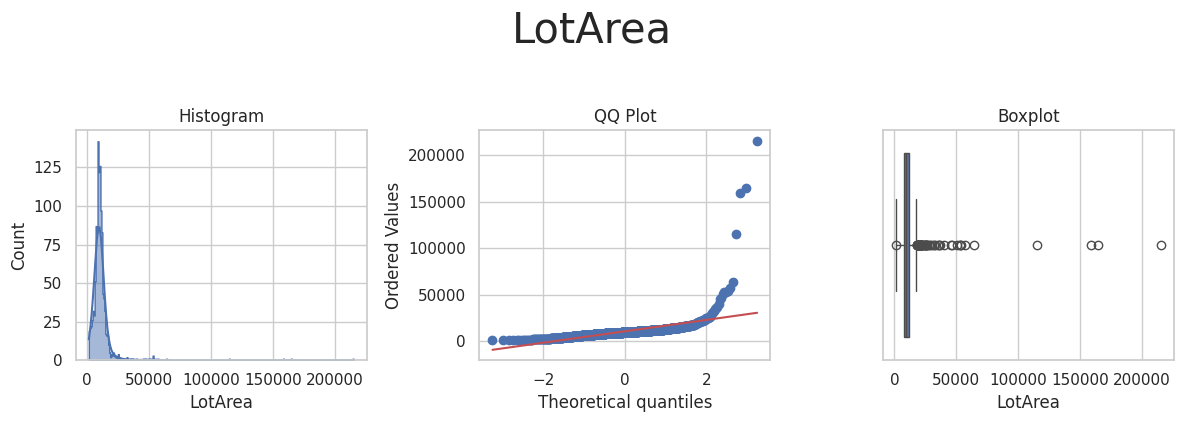

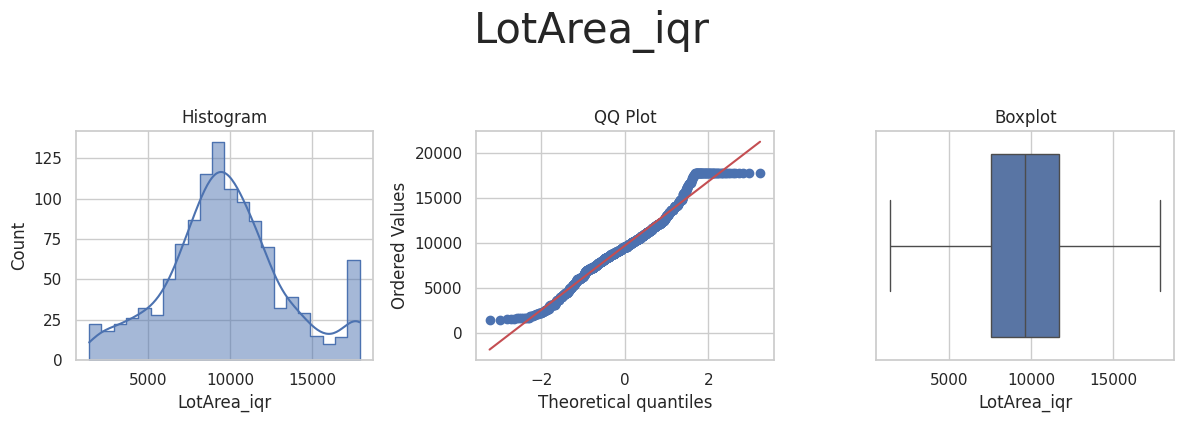



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



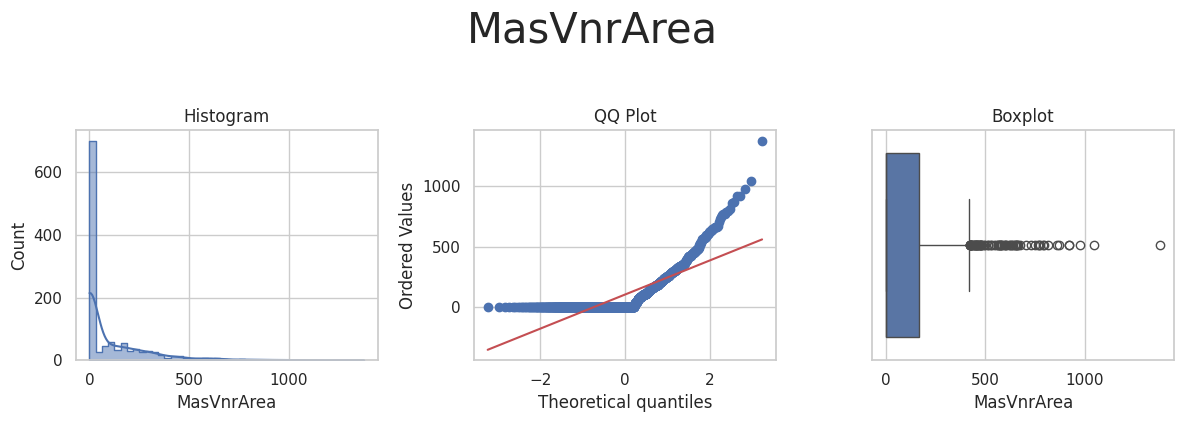

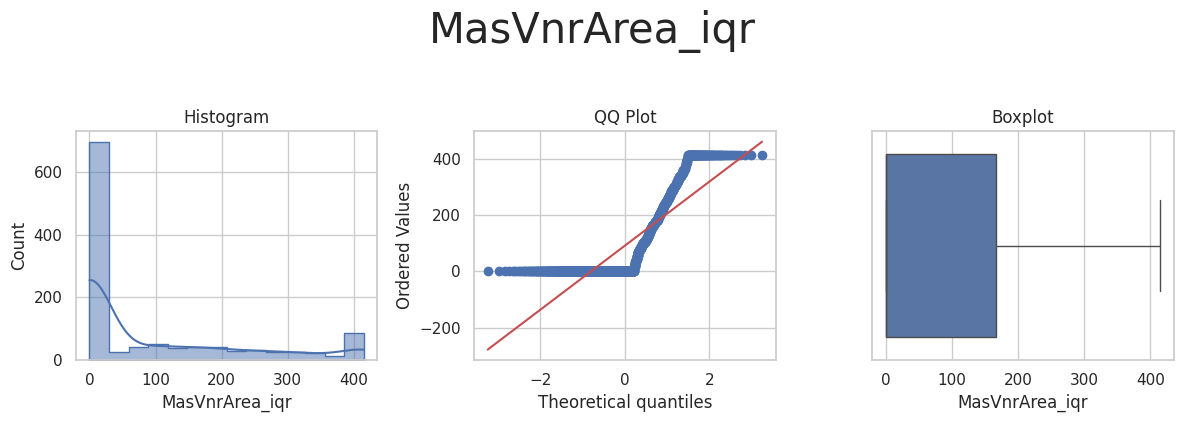



✅ Winsorization complete


In [19]:
# Analyze outliers
df_engineering = TrainSet[num_vars].copy()
FeatureEngineeringAnalysis(TrainSet=df_engineering, analysis_type="outlier_winsorizer")

# (Optional) Apply winsorizer if needed
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=num_vars)
TrainSet = winsor.fit_transform(TrainSet)
TestSet = winsor.transform(TestSet)

print("✅ Winsorization complete")

# Smart Correlation Selection

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection

df_engineering = TrainSet.copy()
corr_sel = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")
TrainSet = corr_sel.fit_transform(TrainSet)
TestSet = TestSet.drop(columns=corr_sel.features_to_drop_)

print("Smart correlation selection complete")
print("Dropped features:", corr_sel.features_to_drop_)

✅ Smart correlation selection complete
❌ Dropped features: ['1stFlrSF', '2ndFlrSF', 'GarageArea', 'GarageYrBlt', 'YearRemodAdd']


# Save Engineered Dataset

In [26]:
import os

# Define directory path
output_dir = "outputs/datasets/engineered/"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Now save the files
TrainSet.to_csv(f"{output_dir}TrainSetEngineered.csv", index=False)
TestSet.to_csv(f"{output_dir}TestSetEngineered.csv", index=False)

print("Feature engineered datasets saved!")

Feature engineered datasets saved!
